# Detroit Land Bank Authority (DLBA) Occupancy Model

Geoff Perrin - 11.29.17

- This notebook is an update to the occupancy model I built for the DLBA last summer that predicts the occupancy of every single-family residential home in the city of Detroit. This model has many uses, but the initial use case was for the DLBA to better manage their housing inventory, and do a quicker and more accurate job sorting the DLBA housing stock into the oppropriate pipeline (i.e. demolition, buy-back, public auction, etc.)

In [1]:
#import data libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(222)
%matplotlib inline

In [2]:
#import machine learning / classification libraries
from sklearn.cross_validation import train_test_split
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier as RFC
import graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import tensorflow as tf
from keras import models
from keras import layers
from keras import losses,optimizers,metrics,activations
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

In [5]:
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

### Load Datasets

In [6]:
data = '../data/OccModel_TrainingInputData_20170117/'

#### DTE data

In [7]:
dte_df = pd.read_csv(data + 'DTE_ActiveAgreementsGasElectric_20160824.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15,17,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
dte_df = dte_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [9]:
### Deduplicate data
dte_df = dte_df.drop_duplicates()

In [10]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_df['DS_SER_PRODUCT_TYPE']]
dte_df = dte_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

#### DWSD (Water Department) data

In [11]:
dwsd_df = pd.read_csv(data + 'DWSD_12MoUsage_20160815.csv')

In [12]:
dwsd_df = dwsd_df[['Ref_ID', 'Street_ID', 'Add_Geocode', 'ZIP', 
                   u'TOTALACCOUNTBALANCE', u'DECEMBER', u'NOVEMBER',
                   u'OCTOBER', u'SEPTEMBER', u'AUGUST', u'JULY', 
                   u'JUNE', u'MAY', u'APRIL',u'MARCH', u'FEBRUARY', 
                   u'JANUARY']]

In [13]:
dwsd_df['year_total'] = dwsd_df.DECEMBER + dwsd_df.NOVEMBER + dwsd_df.OCTOBER + dwsd_df.SEPTEMBER +\
                        dwsd_df.AUGUST + dwsd_df.JULY +dwsd_df.JUNE + dwsd_df.MAY + dwsd_df.APRIL +\
                        dwsd_df.MARCH + dwsd_df.FEBRUARY + dwsd_df.JANUARY

In [14]:
### sum water amounts of duplicate properties 
dwsd_df = dwsd_df.groupby(['Ref_ID'], as_index=False)[ u'TOTALACCOUNTBALANCE',
       u'DECEMBER', u'NOVEMBER', u'OCTOBER', u'SEPTEMBER', u'AUGUST', u'JULY',
       u'JUNE', u'MAY', u'APRIL', u'MARCH', u'FEBRUARY', u'JANUARY',
       u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [15]:
usps_df = pd.read_csv(data + 'Fire_USPS_Data_8_18_16.csv')

In [16]:
usps_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',
       u'DFD Fire: Structure Status']

In [17]:
### subset to residential data
usps_df = usps_df[usps_df['Property Class'] == 'Residential-Structure']

In [18]:
### create DFD fire dummy
usps_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_df['DFD Fire: Occurrence Date']]

In [19]:
### create USPS occupied dummy
usps_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_df['USPS: Vacancy Indicated']]

In [20]:
### Just keep variables we need
usps_df = usps_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [21]:
vote_df = pd.read_csv(data + 'QVF_Detroit20160816.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,2,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
vote_df = vote_df[['Ref_ID']]
vote_df['vote_dummy'] = 1

In [23]:
vote_df = vote_df.drop_duplicates()

#### Blext data (Motor City Mapping data)
- https://motorcitymapping.org/#t=overview&s=detroit&f=all

In [24]:
mcm_df = pd.read_csv(data + 'Recent_Blexts_8_18_16_v2.csv')

In [25]:
mcm_df = mcm_df[[u'Account Name', u'Parcel ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']]

In [26]:
mcm_df.columns = [u'Account Name', u'Ref_ID', u'MCM Structure',
       u'Property Class', u'MCM Occupancy', u'MCM Blext Created At']

In [27]:
### subset to residential data
mcm_df = mcm_df[mcm_df['Property Class'] == 'Residential-Structure']

In [28]:
### subset to non-lot properties
mcm_df = mcm_df[mcm_df['MCM Structure'] == 'Yes']

In [29]:
len(mcm_df)

64783

#### Note from Alice Hargreaves:

NOTE: code "maybe" or "partial" occupied houses as occupied... Ive googled a lot of the "maybes" and theyre nearly all structually sound --- i.e., someone could occupy it, but someone might not be sleeping there every night - GP line of thinking about 3k rows are "maybe" or "partial" 

(R-code below):

In [30]:
def occupancy_binary(x):
    if (x == "Occupied") | (x == "Unoccupied"):
        return x
    else:
        return "Occupied"

In [31]:
mcm_df['MCM Occupancy'] = mcm_df['MCM Occupancy'].apply(occupancy_binary)

In [32]:
### create DFD fire dummy
mcm_df['mcm_occupancy_dummy'] = [1 if x == 'Occupied' else 0 for x in mcm_df['MCM Occupancy']]

### Merge Datasets together

In [33]:
# merge mcm data with usps / dfd data
merged_train = mcm_df.merge(usps_df, how='left', on='Ref_ID')

In [34]:
#merge on voter (qvf) data
merged_train2 = merged_train.merge(vote_df, how='left', on='Ref_ID')

In [35]:
#fill in NaNs for vote_dummy
merged_train2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_train2['vote_dummy']]

In [36]:
#merge on dwsd data
merged_train3 = merged_train2.merge(dwsd_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_train3.fillna(value=0,inplace=True)

In [37]:
#merge on dte data
merged_train_final = merged_train3.merge(dte_df, how='left', on='Ref_ID')
merged_train_final.fillna(value=0,inplace=True)

In [38]:
merged_train_final.head()

,Account Name,Ref_ID,MCM Structure,Property Class,MCM Occupancy,MCM Blext Created At,mcm_occupancy_dummy,fire_occured_dummy,usps_occupied_dummy,vote_dummy,TOTALACCOUNTBALANCE,DECEMBER,NOVEMBER,OCTOBER,SEPTEMBER,AUGUST,JULY,JUNE,MAY,APRIL,MARCH,FEBRUARY,JANUARY,year_total,gas_dummy,electric_dummy
0,13776 St Louis,13011231.,Yes,Residential-Structure,Occupied,8/16/2016 14:52,1,0,1,0,129.35,200.0,8000.0,8100.0,200.0,200.0,200.0,200.0,100.0,200.0,100.0,200.0,100.0,17800.0,1.0,1.0
1,13782 St Louis,13011232.,Yes,Residential-Structure,Occupied,8/16/2016 14:52,1,0,1,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13790 St Louis,13011233.,Yes,Residential-Structure,Occupied,8/16/2016 14:51,1,0,1,0,27.97,900.0,900.0,800.0,800.0,1100.0,900.0,900.0,800.0,800.0,800.0,800.0,1100.0,10600.0,1.0,1.0
3,13777 St Louis,13011536.,Yes,Residential-Structure,Unoccupied,8/16/2016 14:50,0,0,0,0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,13761 St Louis,13011538.,Yes,Residential-Structure,Occupied,8/16/2016 14:49,1,0,1,0,13.87,400.0,300.0,300.0,300.0,300.0,300.0,300.0,200.0,300.0,200.0,300.0,300.0,3500.0,1.0,1.0


In [39]:
merged_train_final.columns

Index([        u'Account Name',               u'Ref_ID',
              u'MCM Structure',       u'Property Class',
              u'MCM Occupancy', u'MCM Blext Created At',
        u'mcm_occupancy_dummy',   u'fire_occured_dummy',
        u'usps_occupied_dummy',           u'vote_dummy',
        u'TOTALACCOUNTBALANCE',             u'DECEMBER',
                   u'NOVEMBER',              u'OCTOBER',
                  u'SEPTEMBER',               u'AUGUST',
                       u'JULY',                 u'JUNE',
                        u'MAY',                u'APRIL',
                      u'MARCH',             u'FEBRUARY',
                    u'JANUARY',           u'year_total',
                  u'gas_dummy',       u'electric_dummy'],
      dtype='object')

In [40]:
len(merged_train_final)

64783

### Visualize Data

In [41]:
data_corr = merged_train_final[['mcm_occupancy_dummy', u'fire_occured_dummy', 
                                u'usps_occupied_dummy',
                                u'vote_dummy', u'TOTALACCOUNTBALANCE', u'DECEMBER',
                                u'NOVEMBER', u'OCTOBER', u'SEPTEMBER', u'AUGUST',
                                u'JULY', u'JUNE', u'MAY', u'APRIL', u'MARCH', u'FEBRUARY',
                                u'JANUARY', u'year_total', u'gas_dummy', u'electric_dummy']]

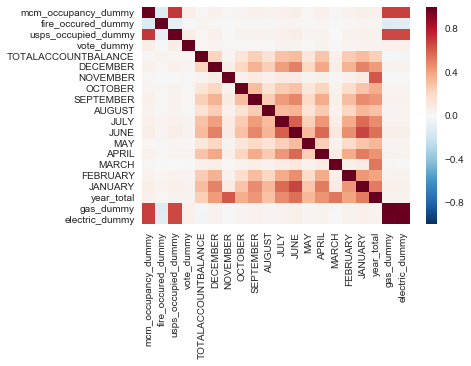

In [42]:
sns.heatmap(data_corr.corr(), annot=False)

In [43]:
data_corr2 = merged_train_final[['mcm_occupancy_dummy', 
                                 u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]

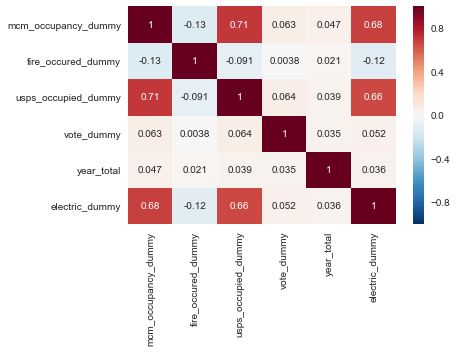

In [44]:
sns.heatmap(data_corr2.corr(), annot=True)

## Classification

In [45]:
merged_train_final.columns

Index([        u'Account Name',               u'Ref_ID',
              u'MCM Structure',       u'Property Class',
              u'MCM Occupancy', u'MCM Blext Created At',
        u'mcm_occupancy_dummy',   u'fire_occured_dummy',
        u'usps_occupied_dummy',           u'vote_dummy',
        u'TOTALACCOUNTBALANCE',             u'DECEMBER',
                   u'NOVEMBER',              u'OCTOBER',
                  u'SEPTEMBER',               u'AUGUST',
                       u'JULY',                 u'JUNE',
                        u'MAY',                u'APRIL',
                      u'MARCH',             u'FEBRUARY',
                    u'JANUARY',           u'year_total',
                  u'gas_dummy',       u'electric_dummy'],
      dtype='object')

In [46]:
X = merged_train_final[[u'fire_occured_dummy', u'usps_occupied_dummy',
                                u'vote_dummy', u'year_total', u'electric_dummy']]
y = merged_train_final.mcm_occupancy_dummy

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Class imbalance correction

In [48]:
merged_train_final.groupby(['mcm_occupancy_dummy'], as_index=False)['fire_occured_dummy'].count()

,mcm_occupancy_dummy,fire_occured_dummy
0,0,12798
1,1,51985


### Logistic Classification

In [49]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
predictions = logmodel.predict(X_test)

In [51]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.85      0.71      0.77      3882
          1       0.93      0.97      0.95     15553

avg / total       0.91      0.92      0.91     19435



In [52]:
print(roc_auc_score(y_test, predictions))

0.839830925966


### use Over Sampling to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [53]:
ros = RandomOverSampler(random_state=0, ratio='minority')
X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

In [54]:
sum(y_train)*1.0 / len(y_train)

0.80338713945488227

In [55]:
sum(y_resampled)*1.0 / len(y_resampled)

0.5

In [56]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [57]:
predictions = logmodel.predict(X_test)

In [58]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.65      0.91      0.76      3882
          1       0.97      0.88      0.92     15553

avg / total       0.91      0.88      0.89     19435



In [59]:
print(roc_auc_score(y_test, predictions))

0.89161756084


### Use SMOTE to correct class imbalance
- code taken from http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html

In [60]:
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)

In [61]:
logmodel = LogisticRegression()
logmodel.fit(X_resampled,y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [62]:
predictions = logmodel.predict(X_test)

In [63]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.65      0.91      0.75      3882
          1       0.97      0.88      0.92     15553

avg / total       0.91      0.88      0.89     19435



In [64]:
print(roc_auc_score(y_test, predictions))

0.891071042484


### Decision Trees

In [65]:
clf = tree.DecisionTreeClassifier()

In [66]:
feature_importance = clf.fit(X_resampled, y_resampled).feature_importances_
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False)

,variables,importance
4,electric_dummy,0.789442
1,usps_occupied_dummy,0.136797
3,year_total,0.0609941
0,fire_occured_dummy,0.00670613
2,vote_dummy,0.00606029


In [67]:
#### Can also use built in sci-kit learn feature selection (Recursive Feature Elimination)

In [68]:
rfe = RFE(clf, n_features_to_select=5)

In [69]:
rfe.fit(X_resampled, y_resampled)

RFE(estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
  n_features_to_select=5, step=1, verbose=0)

In [70]:
# summarize the selection of the attributes
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True]
[1 1 1 1 1]


In [71]:
featured_columns = (np.array(X.columns) * rfe.support_)
featured_columns = [var for var in featured_columns if var]

In [72]:
featured_columns

['fire_occured_dummy',
 'usps_occupied_dummy',
 'vote_dummy',
 u'year_total',
 'electric_dummy']

In [73]:
X_top_features = X[featured_columns]

### Predictions

In [74]:
predictions = rfe.predict(X_test)

In [75]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.70      0.88      0.78      3882
          1       0.97      0.91      0.94     15553

avg / total       0.92      0.90      0.91     19435



In [76]:
def accuracy(true, predictions):
    tot_true = (true == predictions)
    return 1.0 * sum(tot_true) / len(true)

In [77]:
#precision of unoccupied homes
def pct_class_unocc_homes_accually_occ(true, predictions):
    #number of true positives of unoccupied homes
    TP = ((true == 0) & (true == predictions))
    #number of predicted unoccupied homes
    PP = (predictions == 0)
    return 1-(sum(TP)*1.0 / sum(PP))
    

In [78]:
accuracy(y_test, predictions)

0.9016207872395163

In [79]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.29889750918742342

In [80]:
feature_names = [u'fire_occured_dummy', u'usps_occupied_dummy',\
                 u'vote_dummy', u'year_total', u'electric_dummy']

In [81]:
### Export decision tree graph
DC_graph = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(DC_graph) 
graph.render("decision_tree_graph") 

'decision_tree_graph.pdf'

## Random Forest

In [82]:
r_tree = RFC()

In [83]:
param_grid = {'max_depth': [9, 11, 13, 15, 17], 'n_estimators': np.arange(1,602,100)}
r_tree_tuned = GridSearchCV(r_tree, param_grid)
r_tree_tuned.fit(X_resampled, y_resampled)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1, 101, 201, 301, 401, 501, 601]), 'max_depth': [9, 11, 13, 15, 17]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [84]:
feature_importance = r_tree_tuned.best_estimator_.fit(X_resampled, y_resampled).feature_importances_

In [85]:
Feature_importance_df = pd.DataFrame([list(X_train.columns), list(feature_importance)]).T
Feature_importance_df.columns = ["variables", "importance"]
Feature_importance_df.sort_values(by="importance", ascending=False, inplace=True)
Feature_importance_df.reset_index(inplace=True)
Feature_importance_df.drop(u'index', axis=1, inplace=True)

In [86]:
Feature_importance_df

,variables,importance
0,electric_dummy,0.435713
1,usps_occupied_dummy,0.360312
2,year_total,0.186028
3,fire_occured_dummy,0.0111986
4,vote_dummy,0.00674757


In [87]:
r_tree_tuned.best_params_

{'max_depth': 15, 'n_estimators': 301}

In [88]:
predictions = r_tree_tuned.predict(X_test)

In [89]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.71      0.88      0.78      3882
          1       0.97      0.91      0.94     15553

avg / total       0.92      0.90      0.91     19435



### Model Evaluation:

- we want to minimize homes being misclassified as unoccupied when they are really occupied
- this means we want to maximize the precision of 0 (unoccupied) as that minimizes the statement above
- False Negative of 0 means a home is classified as being occupied but is really unoccupied

<img src="Precisionrecall.png",width=300,height=300>

In [90]:
accuracy(y_test, predictions)

0.903010033444816

In [91]:
pct_class_unocc_homes_accually_occ(y_test, predictions)

0.29492708975148896

In [92]:
print(roc_auc_score(y_test, predictions))

0.896004257997


## Dense Neural Network

In [93]:
dnn_keras_model = models.Sequential()
dnn_keras_model.add(layers.Dense(units=10, input_dim=5, activation='relu'))
dnn_keras_model.add(layers.Dense(units=10, input_dim=10, activation='relu'))
dnn_keras_model.add(layers.Dense(units=2, activation='softmax'))

In [94]:
opt = SGD(lr=0.01)
dnn_keras_model.compile(optimizer= opt,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

In [95]:
scaler = MinMaxScaler()

In [96]:
scaled_x_train = scaler.fit_transform(X_resampled)

In [97]:
scaled_x_test = scaler.fit_transform(X_test)

In [98]:
dnn_keras_model.fit(scaled_x_train,y_resampled,epochs=10)

Epoch 1/10
72864/72864 [==============================] - 3s - loss: 0.3615 - acc: 0.8688     
Epoch 2/10
72864/72864 [==============================] - 3s - loss: 0.3064 - acc: 0.8867     
Epoch 3/10
72864/72864 [==============================] - 3s - loss: 0.3057 - acc: 0.8865     
Epoch 4/10
72864/72864 [==============================] - 3s - loss: 0.3054 - acc: 0.8867     
Epoch 5/10
72864/72864 [==============================] - 3s - loss: 0.3050 - acc: 0.8870     
Epoch 6/10
72864/72864 [==============================] - 3s - loss: 0.3050 - acc: 0.8870     
Epoch 7/10
72864/72864 [==============================] - 3s - loss: 0.3048 - acc: 0.8871     
Epoch 8/10
72864/72864 [==============================] - 3s - loss: 0.3048 - acc: 0.8870     
Epoch 9/10
72864/72864 [==============================] - 3s - loss: 0.3048 - acc: 0.8871     
Epoch 10/10
72864/72864 [==============================] - 3s - loss: 0.3049 - acc: 0.8871     


In [99]:
predictions = dnn_keras_model.predict_classes(scaled_x_test)

16576/19435 [========================>.....] - ETA: 0s

In [100]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.63      0.91      0.75      3882
          1       0.98      0.87      0.92     15553

avg / total       0.91      0.88      0.89     19435



In [101]:
print(roc_auc_score(y_test, predictions))

0.890271479685


## Applying Predictions to full dataset

In [102]:
predictions_df = X.copy()

In [103]:
predictions_df['prediction_occupancy'] = r_tree_tuned.predict(X)
predictions_df['prediction_occupancy_proba'] = r_tree_tuned.predict_proba(X)[:,1]

In [104]:
address_df = merged_train_final[['Account Name']]

In [105]:
predictions_df = predictions_df.merge(address_df, how='left', left_index=True, right_index=True)

In [106]:
predictions_df.sort(columns='prediction_occupancy_proba').head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,electric_dummy,prediction_occupancy,prediction_occupancy_proba,Account Name
56766,1,0,0,1600.0,0.0,0,0.0,14625 Greenlawn
51991,1,0,0,1100.0,0.0,0,0.0,6445 Auburn
5005,1,0,1,0.0,0.0,0,0.0,18030 Norwood
14499,1,0,1,0.0,0.0,0,0.0,14414 Evergreen
58718,1,0,1,0.0,0.0,0,0.0,19309 Oakfield


## Read in full data

In [107]:
data_full = '../data/OccModel_FittingFullData_20170922/'

#### DTE data

In [108]:
dte_full_df = pd.read_csv(data_full + 'DTE_ActiveGasElectric_GeocoderMatches_20170920.txt')

In [109]:
dte_full_df = dte_full_df[['Ref_ID', 'DS_SER_PRODUCT_TYPE']]

In [110]:
### Deduplicate data
dte_full_df = dte_full_df.drop_duplicates()

In [111]:
### long to wide reshape on DS_SER_PRODUCT_TYPE
dte_full_df['gas_dummy'] = [1 if x=='GAS' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df['electric_dummy'] = [1 if x=='ELC' else 0 for x in dte_full_df['DS_SER_PRODUCT_TYPE']]
dte_full_df = dte_full_df.groupby(['Ref_ID'], as_index=False)['gas_dummy', 'electric_dummy'].sum()

In [112]:
len(dte_full_df)

186539

#### DWSD (Water Department) data

In [113]:
dwsd_full_df = pd.read_csv(data_full + 'DWSD_12Mo_20170825.csv')

In [114]:
def pandas_to_numeric(s):
    s = s.str.replace(',', '')
    return pd.to_numeric(s, errors='coerce')

In [115]:
dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', u'TWO', u'THREE', \
              u'FOUR', u'FIVE', u'SIX', u'SEVEN',u'EIGHT']] \
            = dwsd_full_df[[u'NINE', u'TEN', u'ELEVEN', u'TWELVE', u'ONE', \
                            u'TWO', u'THREE', u'FOUR', u'FIVE', u'SIX', u'SEVEN',\
                            u'EIGHT']].apply(pandas_to_numeric)

In [116]:
dwsd_full_df['year_total'] = dwsd_full_df.NINE + dwsd_full_df.TEN + dwsd_full_df.ELEVEN + \
                             dwsd_full_df.TWELVE + dwsd_full_df.ONE + dwsd_full_df.TWO + \
                             dwsd_full_df.THREE + dwsd_full_df.FOUR + dwsd_full_df.FIVE + \
                             dwsd_full_df.SIX + dwsd_full_df.SEVEN + dwsd_full_df.EIGHT

In [117]:
dwsd_full_df = dwsd_full_df[['REPAIREDPARCELID', u'year_total']]

In [118]:
dwsd_full_df.columns = ['Ref_ID', 'year_total']

In [119]:
### sum water amounts of duplicate properties 
dwsd_full_df = dwsd_full_df.groupby(['Ref_ID'], as_index=False)[ u'year_total'].sum()

#### USPS / DFD (Fire Department) data

In [120]:
usps_full_df = pd.read_csv(data_full + 'DFD_USPS_20170829.csv')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
usps_full_df.head()

,Account Name,Parcel ID,Property Class,USPS: Last Update,USPS: Vacancy Indicated,DFD Fire: Occurrence Date
0,2411 Wendell,20007595.,Residential-Structure,8/1/2017,No,8/19/2017
1,17208 Ohio,16033858.,Residential-Structure,8/1/2017,No,8/19/2017
2,60 E Euclid,01002534.,Residential-Structure,8/1/2017,No,8/19/2017
3,8154 W Lafayette,20002305.,Residential-Structure,8/1/2017,Yes,8/19/2017
4,16691 Fairmount Dr,21025509.001,Residential-Structure,8/1/2017,No,8/18/2017


In [122]:
usps_full_df.columns = [u'Account Name', u'Ref_ID', u'Property Class', u'USPS: Last Update',
       u'USPS: Vacancy Indicated', u'DFD Fire: Occurrence Date',]

In [123]:
### subset to residential data
usps_full_df = usps_full_df[usps_full_df['Property Class'] == 'Residential-Structure']

In [124]:
### create DFD fire dummy
usps_full_df['fire_occured_dummy'] = [0 if pd.isnull(x) else 1 for x in usps_full_df['DFD Fire: Occurrence Date']]

In [125]:
### create USPS occupied dummy
usps_full_df['usps_occupied_dummy'] = [1 if x == "No" else 0 for x in usps_full_df['USPS: Vacancy Indicated']]

In [126]:
### Just keep variables we need
usps_full_df = usps_full_df[[u'Ref_ID', u'fire_occured_dummy',
                   u'usps_occupied_dummy']]

#### QVF (voter registration) data

In [127]:
vote_full_df = pd.read_csv(data_full + 'QVF_Detroit_Geo_20170717.txt')

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [128]:
vote_full_df = vote_full_df[['Ref_ID']]
vote_full_df['vote_dummy'] = 1

In [129]:
vote_full_df = vote_full_df.drop_duplicates()

#### Address Data

In [130]:
addy_full_df = pd.read_csv(data_full + 'ResStructureParcelsAccountIDs_20170920.csv')

In [131]:
addy_full_df.head()

,Account ID,Parcel ID,Account Name,Property Ownership,Property Class
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure


In [132]:
### subset to residential data
addy_full_df = addy_full_df[addy_full_df['Property Class'] == 'Residential-Structure']

In [133]:
addy_full_df.columns = ['Account_ID', 'Ref_ID', 'Account_Name', 'Property_Ownership', 'Property_Class']

In [134]:
len(addy_full_df)

234869

### Merge Datasets together

In [135]:
# merge mcm data with usps / dfd data
merged_full = addy_full_df.merge(usps_full_df, how='left', on='Ref_ID')

In [136]:
#merge on voter (qvf) data
merged_full2 = merged_full.merge(vote_full_df, how='left', on='Ref_ID')

In [137]:
#fill in NaNs for vote_dummy
merged_full2['vote_dummy'] = [0 if pd.isnull(x) else 1 for x in merged_full2['vote_dummy']]

In [138]:
#merge on dwsd data
merged_full3 = merged_full2.merge(dwsd_full_df, how='left', on='Ref_ID')
#fill in 0s for properties w/ no water
merged_full3.fillna(value=0,inplace=True)

In [139]:
#merge on dte data
merged_full_final = merged_full3.merge(dte_full_df, how='left', on='Ref_ID')
merged_full_final.fillna(value=0,inplace=True)

In [140]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0


In [141]:
merged_full_final.columns

Index([         u'Account_ID',              u'Ref_ID',        u'Account_Name',
        u'Property_Ownership',      u'Property_Class',  u'fire_occured_dummy',
       u'usps_occupied_dummy',          u'vote_dummy',          u'year_total',
                 u'gas_dummy',      u'electric_dummy'],
      dtype='object')

In [142]:
len(merged_full_final)

234869

In [143]:
merged_full_final.head()

,Account_ID,Ref_ID,Account_Name,Property_Ownership,Property_Class,fire_occured_dummy,usps_occupied_dummy,vote_dummy,year_total,gas_dummy,electric_dummy
0,001j000000IeFOx,22126050-1,14200 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,0.0,1.0,1.0
1,001j000000IeFOp,22126047-9,14180 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,9400.0,0.0,0.0
2,001j000000IeFOZ,22126046.,14164 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,2100.0,0.0,0.0
3,001j000000IeFOM,22126045.,14158 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,14700.0,0.0,0.0
4,001j000000IeFO9,22126044.,14150 W Outer Drive,Non-DLBA Owned,Residential-Structure,0.0,1.0,1,3100.0,1.0,1.0
